In [18]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

path = "D:/myData/데이터분석/FastCampus/전처리강의/part-3.-지도학습-주요모델-및-개념/Part 3. 지도학습 주요모델 및 개념/데이터"

In [55]:
df = pd.read_csv(path+"/Combined_Cycle_Power_Plant.csv")

# df = pd.DataFrame(np.random.random(1000)*9821, columns=["rand"])
df.describe()

,T,V,AP,RH,EP
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


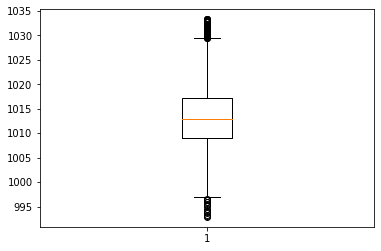

In [59]:
plt.boxplot(df["AP"])
plt.show()

# IQR Rule
---
- IQR Rule은 사분위수를 기준으로 이상치를 탐지하는 방법
- $IQR = Q3-Q1$ 이라고 할 때, $Q1-1.5IQR \leq x \leq Q3+1.5IQR$ 의 $x$를 정상값, 이외의 값을 이상값으로 처리합니다.

In [21]:
# 이상치이면 true를 반환
def IQR_rule(arr, target):
    q1, q3 = np.quantile(arr, 0.25), np.quantile(arr, 0.75)
    IQR = q3-q1
    return (target<(q1-1.5*IQR)) or (target>(q3+1.5*IQR))

In [60]:
outlier = df["AP"].apply(lambda x: IQR_rule(df["AP"], x))
df.loc[outlier,"AP"]

30       994.17
353     1029.60
413     1032.98
521     1030.72
1015     995.88
         ...   
8748    1033.25
8762    1031.71
8942    1029.90
9232    1033.08
9348    1030.18
Name: AP, Length: 88, dtype: float64

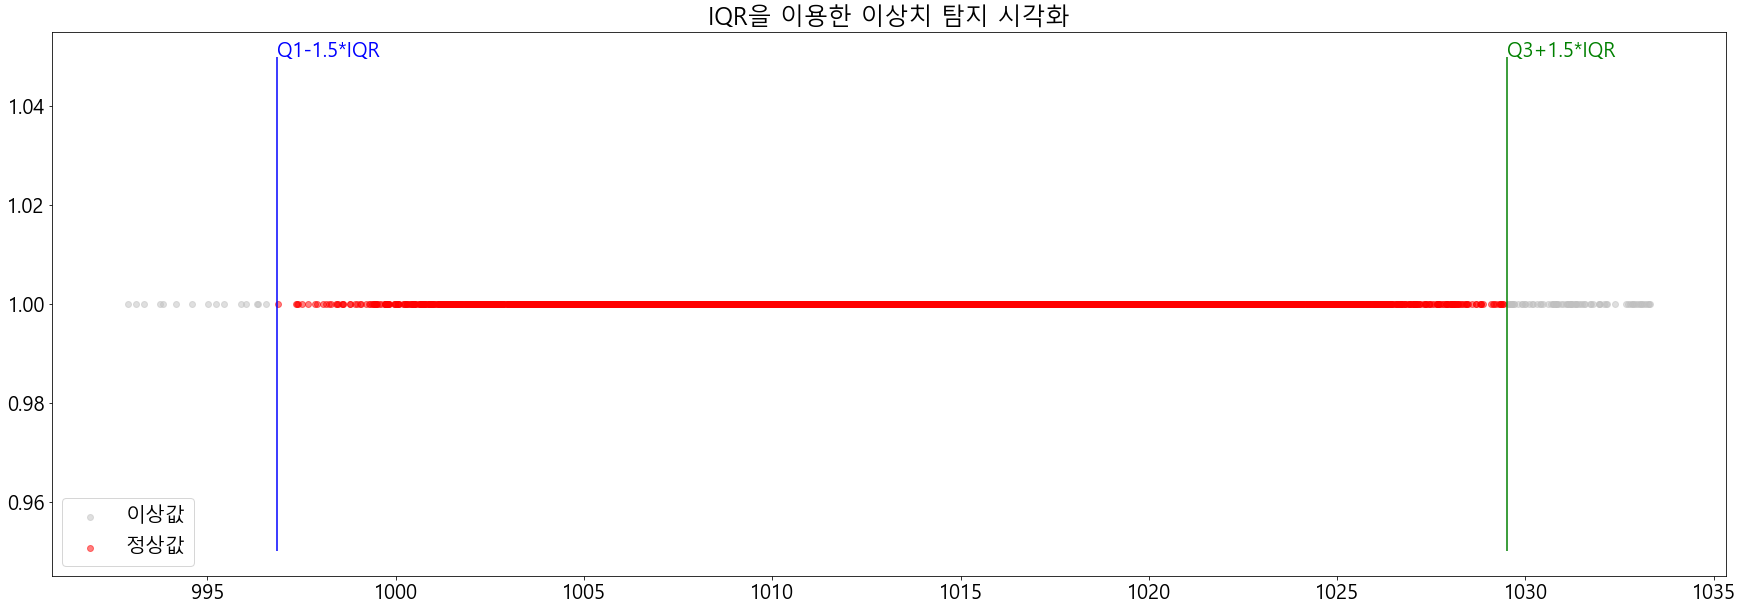

In [112]:
Q1, Q3 = np.quantile(df["AP"], 0.25), np.quantile(df["AP"], 0.75)
IQR = Q3-Q1

plt.rcParams["figure.figsize"] = (30,10)
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = True
plt.rcParams["font.size"] = 20
plt.title("IQR을 이용한 이상치 탐지 시각화")
plt.scatter(df.loc[outlier,"AP"], [1]*len(df.loc[outlier,"AP"]), color="silver", alpha=0.5, label="이상값")
plt.scatter(df.loc[outlier==False]["AP"], [1]*len(df.loc[outlier==False]["AP"]), color="red", alpha=0.5, label="정상값")
plt.vlines(x=Q1-1.5*IQR,ymax=1.05,ymin=0.95,color="blue")
plt.text(Q1-1.5*IQR,1.05,"Q1-1.5*IQR", color="blue")
plt.vlines(x=Q3+1.5*IQR,ymax=1.05,ymin=0.95,color="green")
plt.text(Q3+1.5*IQR,1.05,"Q3+1.5*IQR", color="green")
plt.legend(loc="lower left")
plt.show()

# DBSCAN
---
- DBSCAN은 군집화의 한 방법으로 밀도를 중심으로 군집화 합니다
- 밀도를 만들어 주기 위해 필요한 변수는 `eps`와 `min_samples`입니다.
- DBSCAN은 군집을 이루는 노드와 이상치 노드로 나뉘게 되는데, 이상치 노드를 Noise Vector라고 부릅니다.

> **`eps`**  
- `eps`는 점과 점 사이의 거리로 군집이 되는 최대 거리를 의미합니다.
- `eps`가 1이라고 하면, 1이하의 거리는 모두 하나의 군집으로 묶이게 됩니다.

> **`min_samples`**
- `min_samples`는 최소 군집의 갯수입니다.
- 지정된 `eps`만큼의 거리에 속해 있더라도 최소 군집의 갯수를 만족하지 못하면 Noise Vector로 분리됩니다.

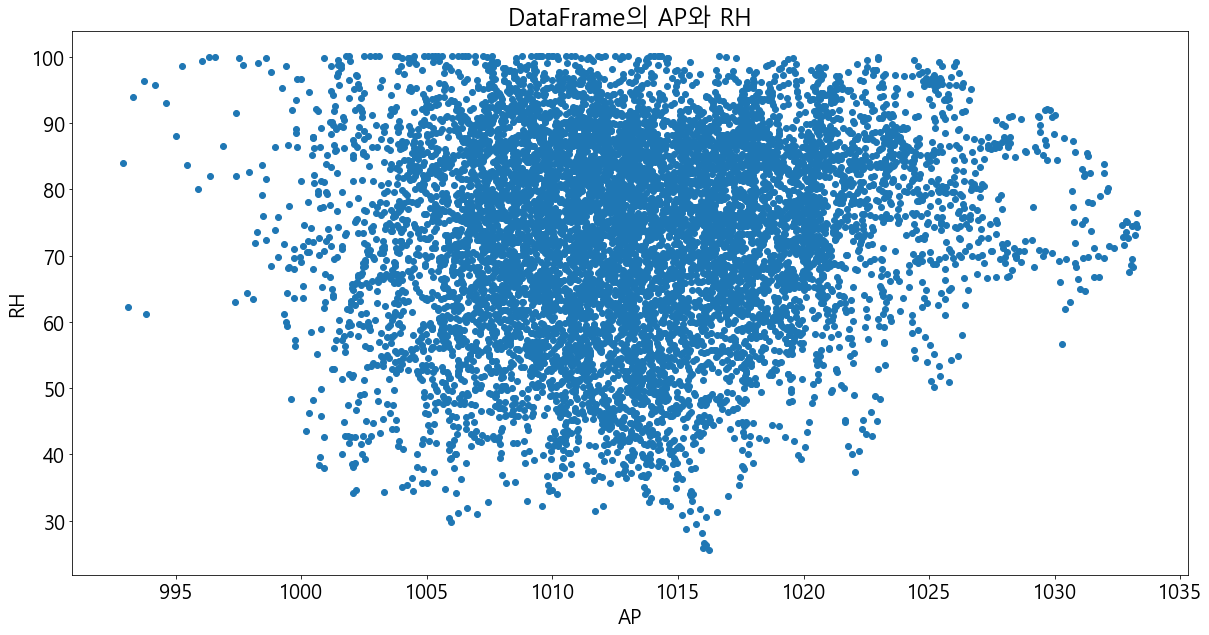

In [105]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("DataFrame의 AP와 RH")
plt.scatter(df["AP"],df["RH"])
plt.xlabel("AP")
plt.ylabel("RH")
plt.show()

In [89]:
from scipy.spatial.distance import cdist

# 거리 행렬 => DBSCAN의 파라미터를 설정하기 위함
DM = cdist(df[["AP", "RH"]],df[["AP", "RH"]],metric="euclidean")

# 샘플 간 거리의 10% quantile 확인
print(np.quantile(DM, 0.05))
DM.shape

4.229657196511323


(9568, 9568)

In [169]:
from sklearn.cluster import DBSCAN

model = DBSCAN(eps=np.quantile(DM, 0.02), min_samples=50, metric="euclidean").fit(df[["AP", "RH"]])
print(sum(model.labels_ == -1)) 

378


In [170]:
df_dbscan = df[["AP","RH"]].copy()
df_dbscan["C"] = model.labels_
df_dbscan

,AP,RH,C
0,1010.84,90.01,0
1,1011.40,74.20,0
2,1007.15,41.91,0
3,1007.22,76.79,0
4,1017.13,97.20,0
...,...,...,...
9563,1011.80,72.93,0
9564,1010.30,59.72,0
9565,1014.20,78.66,0
9566,1018.58,94.65,0


In [171]:
df_dbscan["AP"].values

array([1010.84, 1011.4 , 1007.15, ..., 1014.2 , 1018.58, 1011.86])

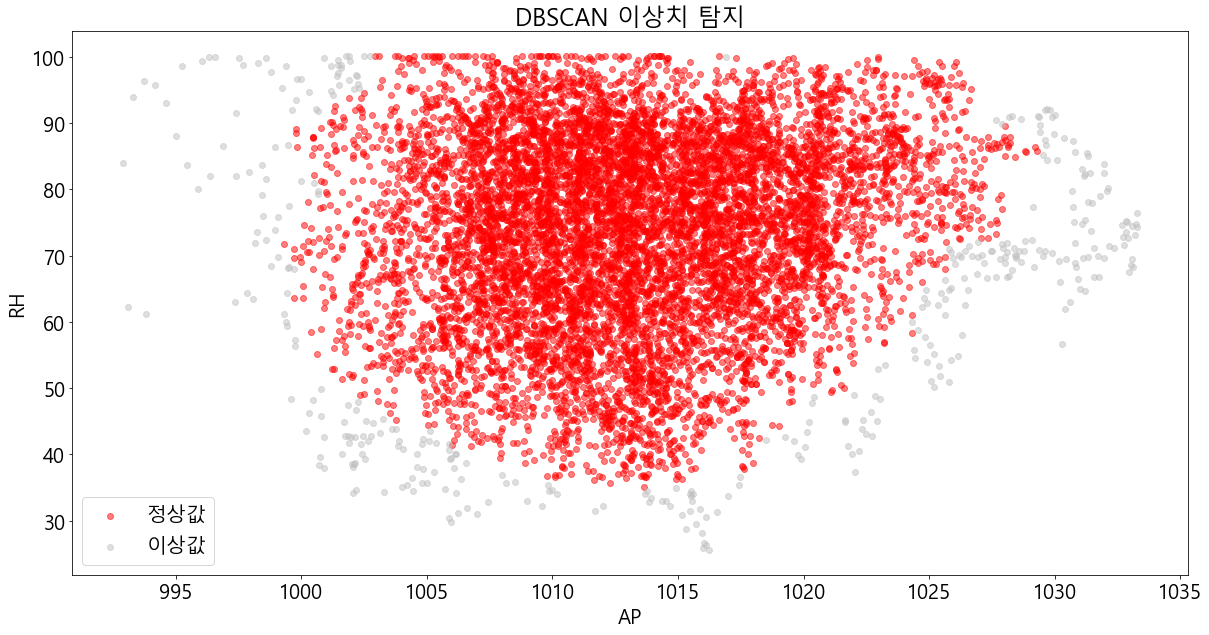

In [172]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("DBSCAN 이상치 탐지")
plt.scatter(df_dbscan.loc[df_dbscan["C"]!=-1]["AP"],
            df_dbscan.loc[df_dbscan["C"]!=-1]["RH"],
            color="red", alpha=.5, label="정상값")
plt.scatter(df_dbscan.loc[df_dbscan["C"]==-1]["AP"],
            df_dbscan.loc[df_dbscan["C"]==-1]["RH"],
            color="silver", alpha=.5, label="이상값")
plt.xlabel("AP")
plt.ylabel("RH")
plt.legend(loc="lower left")
plt.show()

# Isolation Forest
---
- Unsupervised Anomaly Detection의 방법 중 하나
- 현재 가지고 있는 데이터 중 이상치를 탐지할 때 사용
- 랜덤으로 데이터를 split하여 모든 관측치를 고립시키며 구현(재귀적으로 탐색)
- 전수 데이터를 활용하지 않고 비복원 추출로 샘플링한 데이터를 사용하므로 변수가 많은 데이터에서도 효율적으로 작동

> Isolation Forest의 원리  

![isolation_forest_원리](https://github.com/chaaaning/study_DA/blob/main/images/isolation_forest_%EB%B6%84%ED%95%A0%ED%99%94.png?raw=true)
- `(1)`을 보면 초록색 노드가 고립될 때까지 총 7번의 분기가 필요합니다.
- `(2)`를 보면 초록색 노드가 고립될 때까지 총 3번의 분기가 필요합니다.

위와 같은 원리로 각 관측치를 고립시키는 일정 횟수 이하를 이상치로 분리할 수 있게 됩니다.

> Isolation Forest의 동작

![isolation_forest_동작](https://github.com/chaaaning/study_DA/blob/main/images/isolation_forest.png?raw=true)
- 앙상블 기법 답게 의사결정나무를 여러 번 반복하면서 Isolation Forest의 개별 트리인 iTree를 반복하며 앙상블을 수행합니다.
- 트리의 depth가 얕은 경우 (root node와 가까움) 이상치로 판단 될 확률이 높습니다.
- 트리의 depth가 깊은 경우 (terminal node와 가까움) 정상값으로 판단 될 확률이 높습니다.

> iTree의 동작

- `Sub Sampling` : 비복원 추출을 통해 전체 데이터 셋에서 일부를 추출
- `Feature Selection` : 

In [166]:
from sklearn.ensemble import IsolationForest as iForest

iF_model = iForest(bootstrap=True).fit_predict(df[["AP","RH"]])
df_iF = df[["AP","RH"]]
df_iF["iF"] = iF_model

C:\Users\yunjc\AppData\Local\Temp/ipykernel_10248/1267629450.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iF["iF"] = iF_model


In [167]:
df_iF

,AP,RH,iF
0,1010.84,90.01,1
1,1011.40,74.20,1
2,1007.15,41.91,-1
3,1007.22,76.79,1
4,1017.13,97.20,-1
...,...,...,...
9563,1011.80,72.93,1
9564,1010.30,59.72,1
9565,1014.20,78.66,1
9566,1018.58,94.65,-1


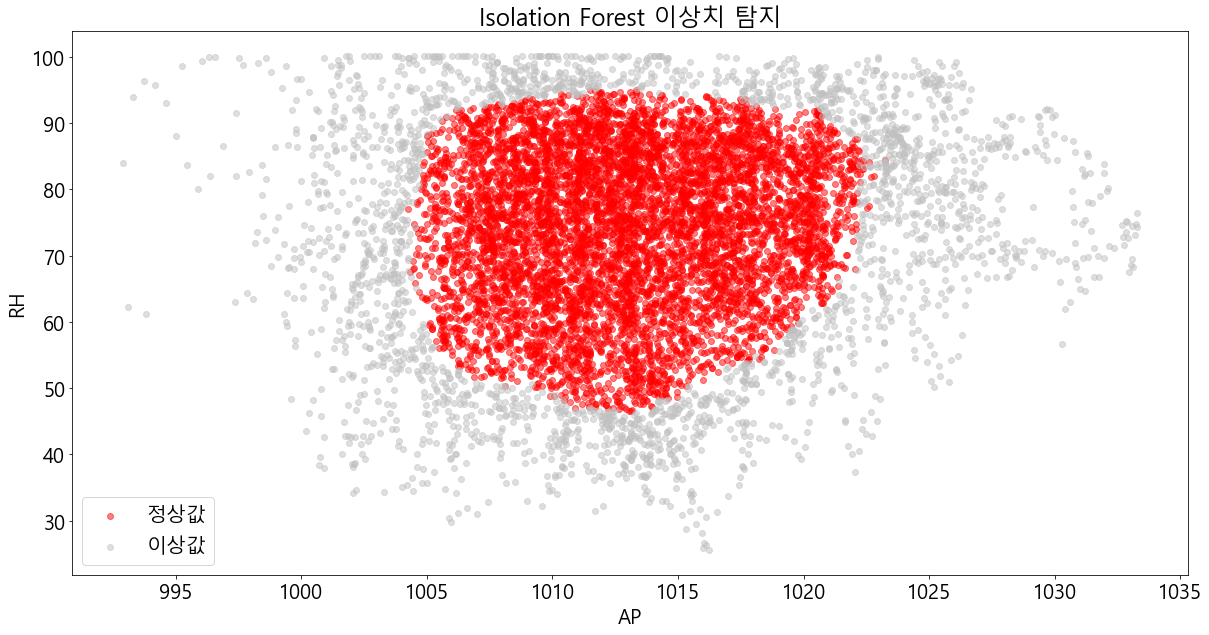

In [168]:
plt.rcParams["figure.figsize"] = (20,10)
plt.title("Isolation Forest 이상치 탐지")
plt.scatter(df_iF.loc[df_iF["iF"]!=-1]["AP"],
            df_iF.loc[df_iF["iF"]!=-1]["RH"],
            color="red", alpha=.5, label="정상값")
plt.scatter(df_iF.loc[df_iF["iF"]==-1]["AP"],
            df_iF.loc[df_iF["iF"]==-1]["RH"],
            color="silver", alpha=.5, label="이상값")
plt.xlabel("AP")
plt.ylabel("RH")
plt.legend(loc="lower left")
plt.show()